In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import pypfopt
from scipy.stats import chi2

In [2]:
def alpha_beta_df(reg_result_dict, beta_name):
    alpha_beta_dict = {}
    for key, value in reg_result_dict.items():
        params_list = [value.params[i] for i in range(len(value.params))]
        bse_list = [value.bse[i] for i in range(len(value.params))]
        pvalue_list = [value.pvalues[i] for i in range(len(value.params))]
        merged_list = [item for z in zip(params_list, bse_list, pvalue_list) for item in z]
        alpha_beta_dict[key] = merged_list

    name_beta_list = ["Beta-{}".format(i) for i in beta_name]
    name_std_list = ["Beta-{}-Standard Error".format(i) for i in beta_name]
    name_pvalue_list = ["Beta-{}-Pvalue".format(i) for i in beta_name]
    name_merged_list = [item for z in zip(name_beta_list, name_std_list, name_pvalue_list) for item in z]
    alpha_beta_df = pd.DataFrame(alpha_beta_dict, index=["Alpha", "Alpha-Standard Error", "Alpha-Pvalue"]+ name_merged_list)
    alpha_beta_df = alpha_beta_df.round(4)
    alpha_beta_df = alpha_beta_df.T
    return alpha_beta_df

In [3]:
def plot_ret_comp(reg_result_dict):
    actual_list = []
    pred_list = []
    for key, value in reg_result_dict.items():
        actual = value.model.endog
        mean_actual = np.mean(actual)
    #     pred = value.fittedvalues
#         pred = value.model.exog[:,1] * value.params[1]
        pred_array = value.model.exog[:,1:] * value.params[1:]
        pred = np.sum(pred_array, axis=1)
        mean_pred = np.mean(pred)
        actual_list.append(mean_actual)
        pred_list.append(mean_pred)

    fig, ax = plt.subplots(1,1,figsize=(6,6))
    ax.scatter(pred_list, actual_list)
    axis_lim = np.max([np.max(pred_list), np.max(actual_list)]) + 0.1
    x_plot = np.linspace(0,axis_lim,100)
    ax.plot(x_plot, x_plot, color="r")
    ax.set_xlim(0, axis_lim)
    ax.set_ylim(0, axis_lim)
    ax.set_xlabel("Predicted Excess Return(% per month)")
    ax.set_ylabel("Actual Excess Return(% per month)")

In [4]:
def t_test_df(reg_result_dict):
    t_result_dict = {}
    for key, value in reg_result_dict.items():
        t_result_dict[key] = [value.tvalues[0], value.pvalues[0]]
    t_result_df = pd.DataFrame(t_result_dict, index=["t-statistic for alpha", "pvalue"])
    t_result_df = t_result_df.round(4)
    display(t_result_df.T)

In [5]:
def GRS_test(mkt_ret, alpha, resid):
    T = resid_array.shape[0]
    alpha = np.asarray(alpha).reshape(-1, 1)
    resid_cov = np.cov(resid, rowvar=False)
    mkt_mean = np.mean(mkt_ret)
    mkt_cov = np.cov(mkt_ret)
    mkt_SRsqr = mkt_mean*mkt_cov**(-1)*mkt_mean
#     mkt_var = np.var(mkt_ret)
#     mkt_SRsqr = mkt_mean**2/mkt_var
    GRS = T*alpha.T@np.linalg.inv(resid_cov)@alpha/(1+mkt_SRsqr)
    df = alpha.shape[0]
    pvalue = chi2.sf(GRS, df)
    return GRS.flatten(), pvalue.flatten()

In [70]:
def plot_efficient_frontier(cla, RF, mkt_mean, mkt_std, points=100, show_assets=True, **kwargs):
    if cla.weights is None:
        cla.max_sharpe()
    optimal_ret, optimal_risk, _ = cla.portfolio_performance(risk_free_rate=RF)

    if cla.frontier_values is None:
        cla.efficient_frontier(points=points)

    mus, sigmas, _ = cla.frontier_values

    fig, ax = plt.subplots()
    ax.plot(sigmas, mus, label="Efficient frontier")

    if show_assets:
        ax.scatter(
            np.sqrt(np.diag(cla.cov_matrix)),
            cla.expected_returns,
            s=30,
            color="k",
            label="assets",
        )

    ax.scatter(
        optimal_risk, optimal_ret, marker="x", s=100, color="g", label="optimal"
    )
    
    tan_ret, tan_vol, tan_SR = cla.portfolio_performance(risk_free_rate=RF)
    q1f_x = np.linspace(0,15,100)
    slope_CML = (tan_ret - RF)/tan_vol
    slope_mkt = (mkt_mean - RF)/mkt_std
    ax.plot(q1f_x, RF + q1f_x * slope_CML, color="r", label="Captial Market Line")
    ax.plot(q1f_x, RF + q1f_x * slope_mkt, color="c", label="Market SR")
    
    ax.legend()
    ax.set_xlim(0)
    ax.set_xlabel("Volatility")
    ax.set_ylabel("Return")
    plt.text(-1.5, RF, "RF", fontsize=12)

#     Plotting._plot_io(**kwargs)
    return ax

In [7]:
port_df = pd.read_csv("25_Portfolios_ME_Prior_12_2.CSV", skiprows=range(0,11))
port_df = port_df.iloc[438:1119]
mom_df = pd.read_csv("F-F_Momentum_Factor.CSV", skiprows=range(0,13))
mom_df = mom_df.iloc[438:1119]
factors5_df = pd.read_csv("F-F_Research_Data_5_Factors_2x3.CSV", skiprows=range(0,3))
factors5_df = factors5_df.iloc[:681]

port_df = port_df.rename(columns={"Unnamed: 0": "YYYY-MM"})
# port_df["YYYY-MM"] = pd.to_datetime(port_df["YYYY-MM"], format="%Y%m")
port_df.set_index("YYYY-MM", inplace=True)
port_df = port_df.astype(float)

mom_df = mom_df.rename(columns={"Unnamed: 0": "YYYY-MM", 'Mom   ': "MOM"})
# mom_df["YYYY-MM"] = pd.to_datetime(mom_df["YYYY-MM"], format="%Y%m")
mom_df.set_index("YYYY-MM", inplace=True)
mom_df = mom_df.astype(float)

factors5_df = factors5_df.rename(columns={"Unnamed: 0": "YYYY-MM"})
# factors5_df["YYYY-MM"] = pd.to_datetime(factors5_df["YYYY-MM"], format="%Y%m")
factors5_df.set_index("YYYY-MM", inplace=True)
factors5_df = factors5_df.astype(float)

factors6_df = pd.concat([factors5_df, mom_df], axis=1)
new_col_names = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'RF']
factors6_df =  factors6_df.reindex(columns=new_col_names)
display(port_df.head())
display(factors6_df.head())

,SMALL LoPRIOR,ME1 PRIOR2,ME1 PRIOR3,ME1 PRIOR4,SMALL HiPRIOR,ME2 PRIOR1,ME2 PRIOR2,ME2 PRIOR3,ME2 PRIOR4,ME2 PRIOR5,...,ME4 PRIOR1,ME4 PRIOR2,ME4 PRIOR3,ME4 PRIOR4,ME4 PRIOR5,BIG LoPRIOR,ME5 PRIOR2,ME5 PRIOR3,ME5 PRIOR4,BIG HiPRIOR
YYYY-MM,,,,,,,,,,,,,,,,,,,,,
196307,-0.19,-1.16,1.11,-0.79,-0.51,-2.16,-1.43,-2.24,-1.43,-0.06,...,-2.70,-1.14,-1.13,-1.53,-1.40,-1.39,-0.40,1.03,0.36,-0.07
196308,1.98,1.84,2.85,2.88,5.83,4.26,4.91,4.19,4.32,7.17,...,5.94,4.55,4.97,4.83,7.94,5.92,4.85,5.78,4.31,7.12
196309,-0.98,-0.97,-0.59,-0.99,0.43,-3.76,-0.93,-0.63,-1.67,-0.82,...,-4.72,-1.61,-2.24,-1.88,-2.20,-2.28,1.51,-1.49,-1.56,-2.62
196310,-0.66,-0.32,1.53,3.11,2.81,3.69,0.29,1.77,2.06,4.26,...,0.01,0.10,0.84,0.71,3.81,2.56,1.60,3.10,0.94,8.51
196311,-2.08,-1.52,-1.44,-1.69,-2.38,-2.76,-0.48,-0.83,-0.97,-1.03,...,1.12,-0.41,-1.18,0.11,-0.20,-1.04,1.77,-0.97,-2.16,-0.70


,Mkt-RF,SMB,HML,RMW,CMA,MOM,RF
YYYY-MM,,,,,,,
196307,-0.39,-0.47,-0.83,0.66,-1.15,1.00,0.27
196308,5.07,-0.79,1.67,0.39,-0.40,1.03,0.25
196309,-1.57,-0.48,0.18,-0.76,0.24,0.16,0.27
196310,2.53,-1.29,-0.10,2.75,-2.24,3.14,0.29
196311,-0.85,-0.84,1.71,-0.45,2.22,-0.75,0.27


## Q1

### (a)

In [8]:
q1_reg_result_dict = {}
for i in range(25):
    colname = port_df.columns[i]
    q1a_Y = (port_df.iloc[:,i] - factors6_df["RF"]).to_numpy()
    q1a_X = factors6_df["Mkt-RF"].to_numpy()
    q1a_X = sm.add_constant(q1a_X)
    q1a_model = sm.OLS(q1a_Y, q1a_X).fit(cov_type="HC1", use_t=True)
    q1_reg_result_dict[colname] = q1a_model

In [9]:
q1_beta_name = ["Mkt"]
q1_alpha_beta_df = alpha_beta_df(q1_reg_result_dict, q1_beta_name)
display(q1_alpha_beta_df)

,Alpha,Alpha-Standard Error,Alpha-Pvalue,Beta-Mkt,Beta-Mkt-Standard Error,Beta-Mkt-Pvalue
SMALL LoPRIOR,-0.7299,0.1889,0.0001,1.3907,0.0592,0.0
ME1 PRIOR2,0.0623,0.1318,0.6364,1.0649,0.0451,0.0
ME1 PRIOR3,0.3593,0.1230,0.0036,1.0109,0.0413,0.0
ME1 PRIOR4,0.4678,0.1235,0.0002,1.0114,0.0393,0.0
SMALL HiPRIOR,0.6412,0.1561,0.0000,1.2161,0.0434,0.0
ME2 PRIOR1,-0.6414,0.1604,0.0001,1.4674,0.0543,0.0
ME2 PRIOR2,0.0492,0.1163,0.6726,1.1440,0.0397,0.0
ME2 PRIOR3,0.2389,0.1004,0.0177,1.0452,0.0346,0.0
ME2 PRIOR4,0.3836,0.1043,0.0003,1.0627,0.0348,0.0
ME2 PRIOR5,0.4716,0.1348,0.0005,1.2887,0.0364,0.0


Betas were precisely estimated because the stocks are splitted into different portfolios for estimation. In addition, the standard errors were relatively small compared to corresponding betas.

### (b)

Based on the pvalues shown on the above table, the pricing errros were mostly significant except for prior2 portfolios and some prior3 and prior 4 portfolios.\
We can conclude that the CAPM model failed to price assets precisely.

### (c)

In [10]:
# fig, axes = plt.subplots(5,5, figsize=(30,30))
# axes = axes.ravel()
# for i, (key, value) in enumerate(reg_result_dict.items()):
#     q1c_y = value.model.endog
#     q1c_x = value.fittedvalues
#     X_plot = np.linspace(-40,40,100)
#     axes[i].scatter(q1c_x, q1c_y)
#     axes[i].plot(X_plot, X_plot)
#     axes[i].set_xlim(-40, 40)
#     axes[i].set_ylim(-40, 40)
#     axes[i].set_xlabel("Predicted Excess Return(% per month)")
#     axes[i].set_ylabel("Actual Excess Return(% per month)")
#     axes[i].set_title(key)

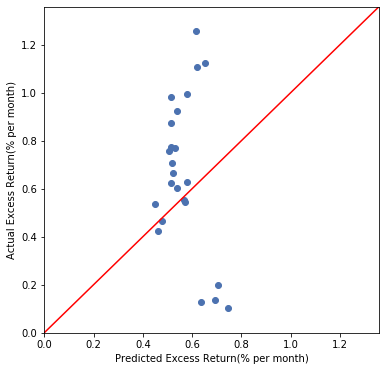

In [11]:
plot_ret_comp(q1_reg_result_dict)

From the vertical difference between data points and the fitted line, which were alphas, we can see that pricing errors significantly larget. Therefore, the CAPM model did not fit well in this case.

### (d)

In [12]:
t_test_df(q1_reg_result_dict)

,t-statistic for alpha,pvalue
SMALL LoPRIOR,-3.8632,0.0001
ME1 PRIOR2,0.4730,0.6364
ME1 PRIOR3,2.9221,0.0036
ME1 PRIOR4,3.7875,0.0002
SMALL HiPRIOR,4.1085,0.0000
ME2 PRIOR1,-3.9996,0.0001
ME2 PRIOR2,0.4227,0.6726
ME2 PRIOR3,2.3785,0.0177
ME2 PRIOR4,3.6763,0.0003
ME2 PRIOR5,3.4980,0.0005


### (e)

In [13]:
resid_list = []
for v in q1_reg_result_dict.values():
    resid_list.append(v.resid)
resid_array = np.asarray(resid_list)
resid_array = resid_array.T
q1_GRS, q1_GRS_pvalue = GRS_test(factors6_df["Mkt-RF"], q1_alpha_beta_df["Alpha"], resid_array)
print("GRS Statistic:", q1_GRS)
print("GRS pvalue:", q1_GRS_pvalue)

GRS Statistic: [135.26862444]
GRS pvalue: [4.13912946e-17]


### (f)

In [14]:
# mu = q1c_actual_list
# S = pypfopt.risk_models.sample_cov(port_df, returns_data=True, frequency=12)
mu = port_df.mean()
S = port_df.cov()
cla = pypfopt.cla.CLA(mu, S, weight_bounds=(-1,1))

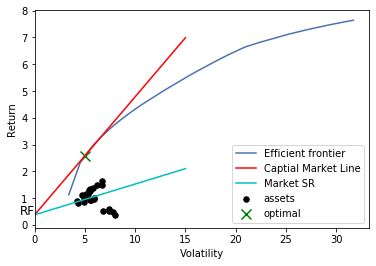

In [15]:
RF_mean = np.mean(factors6_df["RF"])
mkt_nom_ret = factors6_df["Mkt-RF"]+factors6_df["RF"]
mkt_nom_mean = mkt_nom_ret.mean()
mkt_nom_std = mkt_nom_ret.std()
plot_efficient_frontier(cla, RF_mean, mkt_nom_mean, mkt_nom_std)

If the CAPM prices all assets well, the sharpe ratio of the market portfolio will equal to the sharpe ratio of the tangency portfolio. However, given that we observed significant pricing errors, the sharpe ratio of the tangency portfolio is much higher than that of the market portfolio.

### (g)

In sum, the CAPM model was unable to price the FF25 portfolios well based on the significant pricing errors shown on the above table and the difference between the sharpe ratios of the tangency portfolio and market portfolio.

## Q2

### (a)

In [16]:
q2a_reg_result_dict = {}
for i in range(25):
    colname = port_df.columns[i]
    q2a_Y = (port_df.iloc[:,i] - factors6_df["RF"]).to_numpy()
    q2a_X = factors6_df[["Mkt-RF", "SMB", "HML"]].to_numpy()
    q2a_X = sm.add_constant(q2a_X)
    q2a_model = sm.OLS(q2a_Y, q2a_X).fit(cov_type="HC1", use_t=True)
    q2a_reg_result_dict[colname] = q2a_model

In [17]:
q2_beta_name = ["Mkt", "SMB", "HML"]
q2_alpha_beta_df = alpha_beta_df(q2a_reg_result_dict, q2_beta_name)
display(q2_alpha_beta_df)

,Alpha,Alpha-Standard Error,Alpha-Pvalue,Beta-Mkt,Beta-Mkt-Standard Error,Beta-Mkt-Pvalue,Beta-SMB,Beta-SMB-Standard Error,Beta-SMB-Pvalue,Beta-HML,Beta-HML-Standard Error,Beta-HML-Pvalue
SMALL LoPRIOR,-0.9500,0.1366,0.0000,1.1838,0.0458,0.0,1.2386,0.0863,0.0000,0.2530,0.0883,0.0043
ME1 PRIOR2,-0.1666,0.0715,0.0201,0.9254,0.0233,0.0,0.9734,0.0527,0.0000,0.3648,0.0460,0.0000
ME1 PRIOR3,0.1440,0.0604,0.0175,0.8824,0.0191,0.0,0.9040,0.0456,0.0000,0.3468,0.0360,0.0000
ME1 PRIOR4,0.2896,0.0595,0.0000,0.8631,0.0186,0.0,0.9228,0.0306,0.0000,0.2306,0.0313,0.0000
SMALL HiPRIOR,0.5400,0.0833,0.0000,0.9800,0.0278,0.0,1.1563,0.0558,0.0000,-0.0726,0.0465,0.1188
ME2 PRIOR1,-0.8106,0.1229,0.0000,1.3084,0.0476,0.0,0.9522,0.0693,0.0000,0.1946,0.0791,0.0141
ME2 PRIOR2,-0.1412,0.0724,0.0516,1.0355,0.0243,0.0,0.7780,0.0508,0.0000,0.3135,0.0466,0.0000
ME2 PRIOR3,0.0677,0.0552,0.2205,0.9492,0.0164,0.0,0.6934,0.0330,0.0000,0.2841,0.0310,0.0000
ME2 PRIOR4,0.2258,0.0531,0.0000,0.9435,0.0155,0.0,0.7667,0.0272,0.0000,0.2206,0.0261,0.0000
ME2 PRIOR5,0.4217,0.0816,0.0000,1.0776,0.0246,0.0,0.9642,0.0481,0.0000,-0.1626,0.0506,0.0014


Betas were precisely estimated because the stocks are splitted into different portfolios for estimation. In addition, the standard errors were relatively small compared to corresponding betas.

### (b)

Based on the pvalues shown on the above table, around half of the pricing errros were significant. For portfolios with smaller market sizes, the pricing errors were more likely to be significant.
We can conclude that the 3-factor Fama-French model still couldn't price the FF 25 portfolios formed on size and momentum precisely, but it performed better than the CAPM and better for large companies.

### (c)

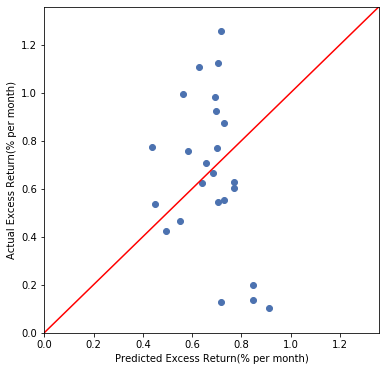

In [18]:
plot_ret_comp(q2a_reg_result_dict)

Pricing errors are still signficantly large for FF 3 factors model, alough slightly better than the CAPM model.

### (d)

In [19]:
t_test_df(q2a_reg_result_dict)

,t-statistic for alpha,pvalue
SMALL LoPRIOR,-6.9536,0.0000
ME1 PRIOR2,-2.3309,0.0201
ME1 PRIOR3,2.3825,0.0175
ME1 PRIOR4,4.8707,0.0000
SMALL HiPRIOR,6.4833,0.0000
ME2 PRIOR1,-6.5945,0.0000
ME2 PRIOR2,-1.9497,0.0516
ME2 PRIOR3,1.2264,0.2205
ME2 PRIOR4,4.2554,0.0000
ME2 PRIOR5,5.1662,0.0000


### (e)

In [20]:
q2_resid_list = []
for v in q2a_reg_result_dict.values():
    q2_resid_list.append(v.resid)
q2_resid_array = np.asarray(q2_resid_list)
q2_resid_array = q2_resid_array.T
q2_GRS, q2_GRS_pvalue = GRS_test(factors6_df["Mkt-RF"], q2_alpha_beta_df["Alpha"], q2_resid_array)
print("GRS Statistic:", q2_GRS)
print("GRS pvalue:", q2_GRS_pvalue)

GRS Statistic: [141.34375432]
GRS pvalue: [3.26187446e-18]


### (f)

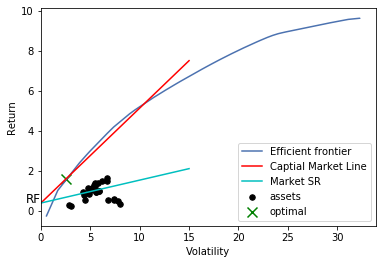

In [59]:
q2f_df = pd.concat([port_df, factors6_df[["Mkt-RF", "SMB", "HML"]]], axis=1)
mu = q2f_df.mean()
S = q2f_df.cov()
cla = pypfopt.cla.CLA(mu, S, weight_bounds=(-1,1))
plot_efficient_frontier(cla, RF_mean, mkt_nom_mean, mkt_nom_std)

### (g)

In sum, the 3-factor FF model performed slightly better for the FF 25 portfolios formed on size and momentum. However, the pricing errors were still significantly large.

## Q3

### (a)

In [22]:
q3a_reg_result_dict = {}
for i in range(25):
    colname = port_df.columns[i]
    q3a_Y = (port_df.iloc[:,i] - factors6_df["RF"]).to_numpy()
    q3a_X = factors6_df[["Mkt-RF", "SMB", "HML", "MOM"]].to_numpy()
    q3a_X = sm.add_constant(q3a_X)
    q3a_model = sm.OLS(q3a_Y, q3a_X).fit(cov_type="HC1", use_t=True)
    q3a_reg_result_dict[colname] = q3a_model

In [23]:
q3_beta_name = ["Mkt", "SMB", "HML", "MOM"]
q3_alpha_beta_df = alpha_beta_df(q3a_reg_result_dict, q3_beta_name)
display(q3_alpha_beta_df)

,Alpha,Alpha-Standard Error,Alpha-Pvalue,Beta-Mkt,Beta-Mkt-Standard Error,Beta-Mkt-Pvalue,Beta-SMB,Beta-SMB-Standard Error,Beta-SMB-Pvalue,Beta-HML,Beta-HML-Standard Error,Beta-HML-Pvalue,Beta-MOM,Beta-MOM-Standard Error,Beta-MOM-Pvalue
SMALL LoPRIOR,-0.3534,0.1174,0.0027,1.0504,0.0264,0.0,1.2417,0.0449,0.0000,-0.0018,0.0561,0.9750,-0.6956,0.0586,0.0000
ME1 PRIOR2,0.0457,0.0603,0.4492,0.8780,0.0175,0.0,0.9745,0.0379,0.0000,0.2742,0.0323,0.0000,-0.2475,0.0231,0.0000
ME1 PRIOR3,0.2158,0.0593,0.0003,0.8663,0.0174,0.0,0.9044,0.0415,0.0000,0.3161,0.0295,0.0000,-0.0837,0.0251,0.0009
ME1 PRIOR4,0.2170,0.0646,0.0008,0.8794,0.0181,0.0,0.9224,0.0318,0.0000,0.2616,0.0336,0.0000,0.0847,0.0273,0.0020
SMALL HiPRIOR,0.2917,0.0823,0.0004,1.0355,0.0237,0.0,1.1550,0.0508,0.0000,0.0335,0.0426,0.4325,0.2896,0.0358,0.0000
ME2 PRIOR1,-0.1937,0.0794,0.0150,1.1704,0.0179,0.0,0.9555,0.0308,0.0000,-0.0689,0.0307,0.0252,-0.7195,0.0437,0.0000
ME2 PRIOR2,0.1245,0.0601,0.0386,0.9761,0.0149,0.0,0.7794,0.0327,0.0000,0.2001,0.0281,0.0000,-0.3099,0.0273,0.0000
ME2 PRIOR3,0.1163,0.0567,0.0406,0.9383,0.0164,0.0,0.6936,0.0308,0.0000,0.2633,0.0276,0.0000,-0.0567,0.0199,0.0045
ME2 PRIOR4,0.1477,0.0543,0.0067,0.9610,0.0143,0.0,0.7663,0.0294,0.0000,0.2539,0.0252,0.0000,0.0910,0.0203,0.0000
ME2 PRIOR5,0.1173,0.0645,0.0695,1.1456,0.0205,0.0,0.9626,0.0341,0.0000,-0.0326,0.0355,0.3595,0.3549,0.0233,0.0000


Betas were precisely estimated because the stocks are splitted into different portfolios for estimation. In addition, the standard errors were relatively small compared to corresponding betas.

### (b)

Based on the pvalues shown on the above table, majority of the pricing errros were insignificant. 
We can conclude that the 4-factor Fama-French-Carhart model the FF 25 portfolios formed on size and momentum much better than the 3-factor Fama-French model and the CAPM model.

### (c)

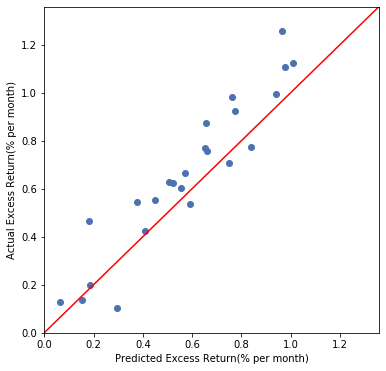

In [24]:
plot_ret_comp(q3a_reg_result_dict)

The 4-factor Fama-French-Carhart model fitted much better than the CAPM model and the 3-factor Fama-French model, because the data points were aligned near the diagonal line. This means predicted excess returns and actual excess returns were close. In other words, pricing errors were relatively small.

### (d)

In [25]:
t_test_df(q3a_reg_result_dict)

,t-statistic for alpha,pvalue
SMALL LoPRIOR,-3.0116,0.0027
ME1 PRIOR2,0.7572,0.4492
ME1 PRIOR3,3.6378,0.0003
ME1 PRIOR4,3.3617,0.0008
SMALL HiPRIOR,3.5444,0.0004
ME2 PRIOR1,-2.4377,0.0150
ME2 PRIOR2,2.0728,0.0386
ME2 PRIOR3,2.0519,0.0406
ME2 PRIOR4,2.7185,0.0067
ME2 PRIOR5,1.8178,0.0695


### (e)

In [26]:
q3_resid_list = []
for v in q3a_reg_result_dict.values():
    q3_resid_list.append(v.resid)
q3_resid_array = np.asarray(q3_resid_list)
q3_resid_array = q3_resid_array.T
q3_GRS, q3_GRS_pvalue = GRS_test(factors6_df["Mkt-RF"], q3_alpha_beta_df["Alpha"], q3_resid_array)
print("GRS Statistic:", q3_GRS)
print("GRS pvalue:", q3_GRS_pvalue)

GRS Statistic: [111.68228867]
GRS pvalue: [6.30951207e-13]


### (f)

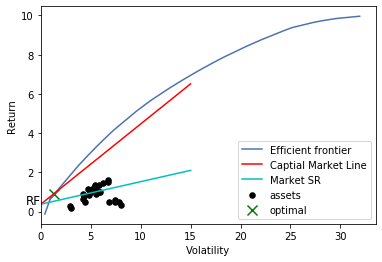

In [71]:
q3f_df = pd.concat([port_df, factors6_df[["Mkt-RF", "SMB", "HML", "MOM"]]], axis=1)
mu = q3f_df.mean()
S = q3f_df.cov()
cla = pypfopt.cla.CLA(mu, S, weight_bounds=(-1,1))
plot_efficient_frontier(cla, RF_mean, mkt_nom_mean, mkt_nom_std)

### (g)

In sum, the 4-factor Fama-French-Carhart model fitted well for the FF 25 portfolios formed on size and momentum, although there still existed some pricing errors to address.

## Q4

### (a)

In [48]:
q4_step1_dict = {}
for i in range(25):
    colname = port_df.columns[i]
    q4_Y = (port_df.iloc[:,i] - factors6_df["RF"]).to_numpy()
    q4_X = factors6_df["Mkt-RF"].to_numpy()
    q4_X = sm.add_constant(q4_X)
    q4_step1_model = sm.OLS(q4_Y, q4_X).fit(cov_type="HC1", use_t=True)
    q4_step1_dict[colname] = q4_step1_model

In [49]:
q4_beta_array = []
Re_list = []
for key, value in q3a_reg_result_dict.items():
    q4_pf_beta_list = [value.params[i] for i in range(1, len(value.params))]
    q4_beta_array.append(q4_pf_beta_list)
    Rie = value.model.endog
    mean_Rie = np.mean(Rie)
    Re_list.append(mean_Rie)
q4_beta_array = np.asarray(q4_beta_array)

In [50]:
# q4_beta_array = sm.add_constant(q4_beta_array)
q4_step2_model = sm.OLS(Re_list, q4_beta_array).fit(cov_type="HC1", use_t=True)

In [51]:
# q4_step2_model.summary(yname="Excess Return", xname=["const", "$\lambda_{Mkt}$", '$\lambda_{SMB}$', "$\lambda_{HML}$", "$\lambda_{MOM}$"])
q4_step2_model.summary(yname="Excess Return", xname=["$\lambda_{Mkt}$", '$\lambda_{SMB}$', "$\lambda_{HML}$", "$\lambda_{MOM}$"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Excess Return   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                              222.4
Date:                Thu, 30 Apr 2020   Prob (F-statistic):                    7.29e-17
Time:                        23:37:52   Log-Likelihood:                          17.308
No. Observations:                  25   AIC:                                     -26.62
Df Residuals:                      21   BIC:                                     -21.74
Df Model:                           4                                                  
Covariance Type:                  HC1                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
$\lambda_{Mkt}$     0.5483      0.045     12.180      0.000       0.455       0.642
$\lambda_{SMB}$     0.1908      0.085      2.249      0.035       0.014       0.367
$\lambda_{HML}$     0.6510      0.171      3.800      0.001       0.295       1.007
$\lambda_{MOM}$     0.7718      0.075     10.227      0.000       0.615       0.929
==============================================================================
Omnibus:                        1.437   Durbin-Watson:                   1.455
Prob(Omnibus):                  0.488   Jarque-Bera (JB):                0.558
Skew:                          -0.340   Prob(JB):                        0.757
Kurtosis:                       3.273   Cond. No.                         8.36
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### (b)

In [52]:
# q4_lambda_comp = pd.DataFrame({"Estimated Risk Premia": q4_step2_model.params[1:],
#                                "Model Risk Premia": factors6_df.mean()[["Mkt-RF", "SMB", "HML", "MOM"]]},
#                                index = ["Mkt-RF", "SMB", "HML", "MOM"])
q4_lambda_comp = pd.DataFrame({"Estimated Risk Premia": q4_step2_model.params,
                               "Model Risk Premia": factors6_df.mean()[["Mkt-RF", "SMB", "HML", "MOM"]]},
                               index = ["Mkt-RF", "SMB", "HML", "MOM"])
display(q4_lambda_comp)

,Estimated Risk Premia,Model Risk Premia
Mkt-RF,0.548335,0.507166
SMB,0.190811,0.207841
HML,0.651040,0.266960
MOM,0.771827,0.663421


3 out of 4 factors including excess market return, size, and momentum were relatively close between estiamted and model's risk premium. However, the estimated risk premia for the value factor was very far from the model value. This is because the way the 25 portfolios were formed was not basd on value. Therefore, the 4-factor model failed to precisely estimate the risk premia for the value factor.

### (c)

In [53]:
q4_alpha_comp = pd.DataFrame()
q4_alpha_comp["Q3_Alpha"] = q3_alpha_beta_df["Alpha"]
# q4_alpha_comp["Q4_Alpha"] = q4_step2_model.resid + q4_step2_model.params[0]
q4_alpha_comp["Q4_Alpha"] = q4_step2_model.resid
display(q4_alpha_comp)

,Q3_Alpha,Q4_Alpha
SMALL LoPRIOR,-0.3534,-0.299446
ME1 PRIOR2,0.0457,-0.052358
ME1 PRIOR3,0.2158,0.083159
ME1 PRIOR4,0.2170,0.086855
SMALL HiPRIOR,0.2917,0.224486
ME2 PRIOR1,-0.1937,-0.121096
ME2 PRIOR2,0.1245,0.054337
ME2 PRIOR3,0.1163,-0.005509
ME2 PRIOR4,0.1477,0.013832
ME2 PRIOR5,0.1173,0.060581


The pricing errors in Question 3 and Question 4 are relatively close. This is because SMB, HML and MOM are excess returns.

### (d)

In [34]:
port4_name_list = ["SMALL LoPRIOR", "SMALL HiPRIOR", "BIG LoPRIOR", "BIG HiPRIOR"]
q4d_port_df = port_df[port4_name_list]
q4d_porte_df = q4d_port_df.subtract(factors6_df["RF"], axis=0)

In [38]:
rowlen = q4d_porte_df.shape[0]
SL_beta_list, SH_beta_list, BL_beta_list, BH_beta_list = [], [], [], []
beta_list = [SL_beta_list, SH_beta_list, BL_beta_list, BH_beta_list]
for t in range(rowlen-60):
    beta_array = []
    for j in range(4):
        ts_Y_jt = q4d_porte_df.iloc[t:t+60,j].to_numpy()
        ts_X_t = factors6_df[["Mkt-RF", "SMB", "HML", "MOM"]].iloc[t:t+60,:].to_numpy()
        ts_X_t = sm.add_constant(ts_X_t)
        ts_model_jt = sm.OLS(ts_Y_jt, ts_X_t).fit(cov_type="HC1", use_t=True)
        beta_list[j].append(ts_model_jt.params[1:])

SL_beta_array = np.asarray(SL_beta_list)
SH_beta_array = np.asarray(SH_beta_list)
BL_beta_array = np.asarray(BL_beta_list)
BH_beta_array = np.asarray(BH_beta_list)
beta_array_list = [SL_beta_array, SH_beta_array, BL_beta_array, BH_beta_array]

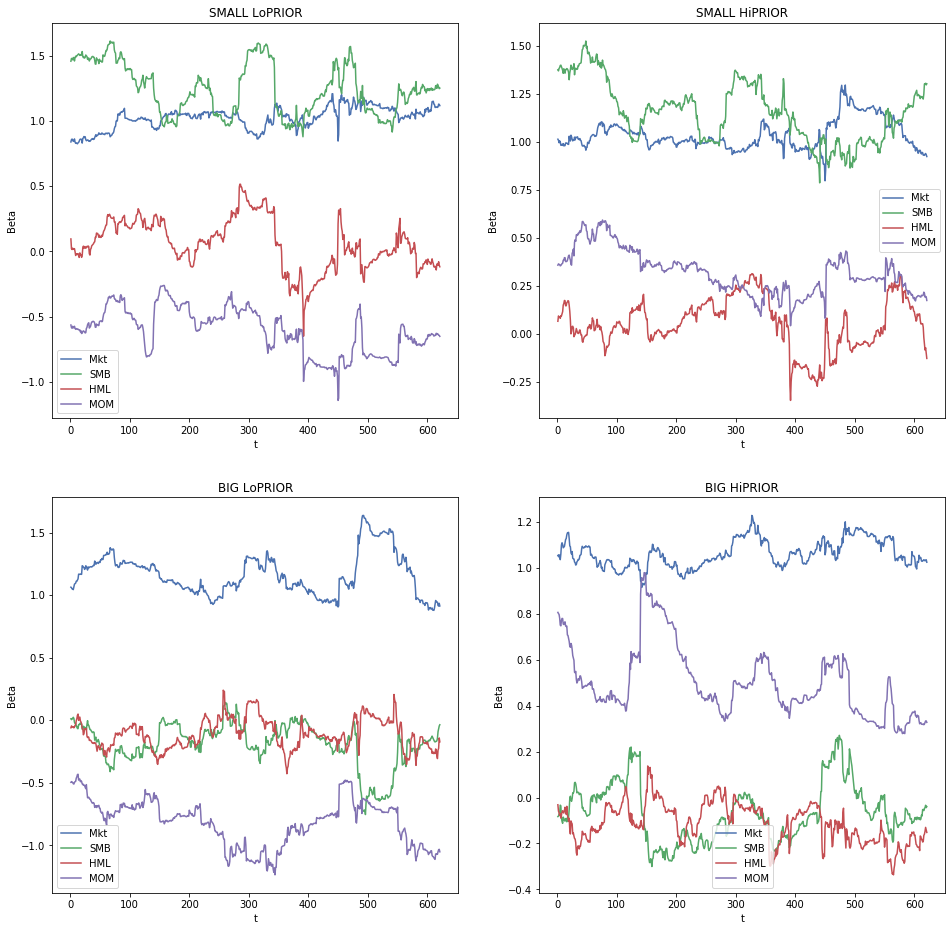

In [39]:
fig, axes = plt.subplots(2,2,figsize=(16,16))
axes = axes.ravel()
for i, ba in enumerate(beta_array_list):
    x = range(1, ba.shape[0]+1)
    axes[i].plot(x, ba[:,0], label="Mkt")
    axes[i].plot(x, ba[:,1], label="SMB")
    axes[i].plot(x, ba[:,2], label="HML")
    axes[i].plot(x, ba[:,3], label="MOM")
    axes[i].set_xlabel("t")
    axes[i].set_ylabel("Beta")
    axes[i].set_title(port4_name_list[i])
    axes[i].legend(loc="best")

From the above plots, we can tell that the betas varied over time.

### (e)(a)

In [40]:
q4e_porte_df = port_df.subtract(factors6_df["RF"], axis=0)

In [41]:
rowlen = q4e_porte_df.shape[0]
lambda_array = []
resid_array = []
# rowlen = 65
for t in range(rowlen-60):
    beta_array = []
    for j in range(25):
        ts_Y_jt = q4e_porte_df.iloc[t:t+60,j].to_numpy()
        ts_X_t = factors6_df[["Mkt-RF", "SMB", "HML", "MOM"]].iloc[t:t+60,:].to_numpy()
        ts_X_t = sm.add_constant(ts_X_t)
        ts_model_jt = sm.OLS(ts_Y_jt, ts_X_t).fit(cov_type="HC1", use_t=True)
        beta_array.append(ts_model_jt.params[1:])
    
    cros_Y_tp60 = q4e_porte_df.iloc[t+60,:]
    cross_X_tp60 = np.asarray(beta_array)
#     cross_X_tp60 = sm.add_constant(cross_X_tp60)
    cross_model_tp60 = sm.OLS(cros_Y_tp60, cross_X_tp60).fit(cov_type="HC1", use_t=True)
#     print(cross_model_tp60.params)
    lambda_array.append(cross_model_tp60.params)
    resid_array.append(cross_model_tp60.resid)

lambda_array = np.asarray(lambda_array)
resid_array = np.asarray(resid_array)

In [42]:
mean_coeff = np.mean(lambda_array, axis=0)
# var_const = 1/(lambda_array.shape[0]) * np.cov(lambda_array[:,0])
# var_lambda = 1/(lambda_array.shape[0]) * np.cov(lambda_array[:,1:], rowvar=False)
# std_list = np.sqrt([var_const, var_lambda.item(0,0), var_lambda.item(1,1), var_lambda.item(2,2), var_lambda.item(3,3)])
var_lambda = 1/(lambda_array.shape[0]) * np.cov(lambda_array, rowvar=False)
std_list = np.sqrt([var_lambda.item(0,0), var_lambda.item(1,1), var_lambda.item(2,2), var_lambda.item(3,3)])

In [43]:
q4ea_df = pd.DataFrame({"Coefficient": mean_coeff, "Standard Errors": std_list},
                       index=["$\lambda_{Mkt}$", '$\lambda_{SMB}$', "$\lambda_{HML}$", "$\lambda_{MOM}$"])
display(q4ea_df)

,Coefficient,Standard Errors
$\lambda_{Mkt}$,0.530177,0.182984
$\lambda_{SMB}$,0.136301,0.124214
$\lambda_{HML}$,0.232969,0.155449
$\lambda_{MOM}$,0.655556,0.174048


### (e)(b)

In [44]:
q4e_lambda_comp = pd.DataFrame({"Estimated Risk Premia": mean_coeff,
                               "Model Risk Premia": factors6_df.mean()[["Mkt-RF", "SMB", "HML", "MOM"]]},
                               index = ["Mkt-RF", "SMB", "HML", "MOM"])
display(q4e_lambda_comp)

,Estimated Risk Premia,Model Risk Premia
Mkt-RF,0.530177,0.507166
SMB,0.136301,0.207841
HML,0.232969,0.266960
MOM,0.655556,0.663421


The estiamted risk premium were close to the model risk premium. Compared to the regressions without rolling windows, the results here were more close.

### (e)(c)

In [45]:
q4e_alpha = np.mean(resid_array, axis=0)
q4e_alpha_comp = pd.DataFrame()
q4e_alpha_comp["Q3_Alpha"] = q3_alpha_beta_df["Alpha"]
q4e_alpha_comp["Q4e_Alpha"] = q4e_alpha
display(q4e_alpha_comp)

,Q3_Alpha,Q4e_Alpha
SMALL LoPRIOR,-0.3534,-0.486200
ME1 PRIOR2,0.0457,-0.031811
ME1 PRIOR3,0.2158,0.180328
ME1 PRIOR4,0.2170,0.127946
SMALL HiPRIOR,0.2917,0.238997
ME2 PRIOR1,-0.1937,-0.287331
ME2 PRIOR2,0.1245,0.052120
ME2 PRIOR3,0.1163,0.094807
ME2 PRIOR4,0.1477,0.096511
ME2 PRIOR5,0.1173,0.059637


Compared to the regressions without rolling windows, the pricing errors here were more close to the pricing errors in Q3.

### (e)(d)

The same as Q4(e)